In [1]:
from src import db

db.models.EquityDailyBar.latest("SPY")

datetime.date(2023, 3, 30)

In [1]:
from src import db
import pandas as pd
import sqlalchemy as sa
import yfinance as yf
import pandas_datareader as pdr

db.client.conn.create_all()

from datetime import date, timedelta
from dateutil import parser

today = date.today()
last_working_day = today - timedelta(days=today.weekday() % 7 or 1)

with db.SessionContext() as session:
    for meta in db.models.Meta.query(session=session).all():
        print(meta.id)

        latest_record = (
            session.query(sa.func.max(db.models.EquityDailyBar.date))
            .select_from(db.models.EquityDailyBar)
            .join(db.models.Meta, db.models.Meta.id == db.models.EquityDailyBar.meta_id)
            .filter(db.models.Meta.ticker == meta.ticker)
            .scalar()
        )

        if latest_record:
            if latest_record >= last_working_day:
                continue

        source = db.models.Source.query(meta_id=meta.id).one_or_none()

        if not source or source.source == "NOTSET":
            continue

        if source.source == "yahoo":
            ticker = yf.Ticker(meta.ticker)
            hist = ticker.history(period="max", auto_adjust=False).reset_index()

        elif source.source == "naver":
            hist = (
                pdr.DataReader(meta.ticker, "naver", latest_record or "1900-1-1")
                .astype(float)
                .reset_index()
            )

        else:
            continue

        if hist.empty:
            continue

        cols = {
            "Date": "date",
            "Open": "open",
            "High": "high",
            "Low": "low",
            "Close": "close",
            "Adj Close": "adj_close",
            "Volume": "volume",
            "Dividends": "dvds",
            "Stock Splits": "splits",
        }
        hist = hist.rename(columns=cols)
        hist["open"] = hist["open"].round(2)
        hist["high"] = hist["high"].round(2)
        hist["low"] = hist["low"].round(2)
        hist["close"] = hist["close"].round(2)
        hist["pre_close"] = hist["close"].shift(1).bfill()
        hist["meta_id"] = meta.id
        if source.source == "yahoo":
            hist["tot_return"] = (hist["close"] + hist["dvds"]) / hist["pre_close"] - 1
            hist["tot_return"] = hist["tot_return"].round(10)
        elif source.source == "naver":
            hist["tot_return"] = hist["close"].pct_change().fillna(0).round(10)

        if latest_record:
            hist = hist.loc[hist.date > parser.parse(str(latest_record))]
        print(hist)
        db.models.EquityDailyBar.insert(hist, session=session)
        session.commit()


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
Empty DataFrame
Columns: [date, open, high, low, close, volume, pre_close, meta_id, tot_return]
Index: []
insert into tb_equity_daly_bar: 0 records.
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
Empty DataFrame
Columns: [date, open, high, low, close, volume, pre_close, meta_id, tot_return]
Index: []
insert into tb_equity_daly_bar: 0 records.
99
100
101
102
103
104
105
106
107
108
Empty DataFrame
Columns: [date, open, high, low, close, volume, pre_close, meta_id, tot_return]
Index: []
insert into tb_equity_daly_bar: 0 records.
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
1

In [ ]:
import inspect
import pandas as pd
from src import db
from src.config import DATABASE_EXC

print(DATABASE_EXC)
# db.client.conn.create_all()

with db.SessionContext() as session:
    for name, obj in inspect.getmembers(db.models):
        
        if inspect.isclass(obj):
            print(obj)
            tablename = obj.__tablename__
            try:
                records = pd.read_excel(DATABASE_EXC, sheet_name=tablename)
            except:
                continue
            obj.update(records=records, session=session)
            print(f"update {name} complete")

        
        

In [ ]:

from src.core import metrics

import yfinance as yf

prices = yf.download("SPY, AGG")["Adj Close"]

start = metrics.to_starts(prices)
end = metrics.to_ends(prices)
end - start

[*********************100%***********************]  8 of 8 completed
simulate |██████████████████████████████████████████████████| 100.00% 6034.59
value    0.080305
value    0.178580
value    0.449688
dtype: float64


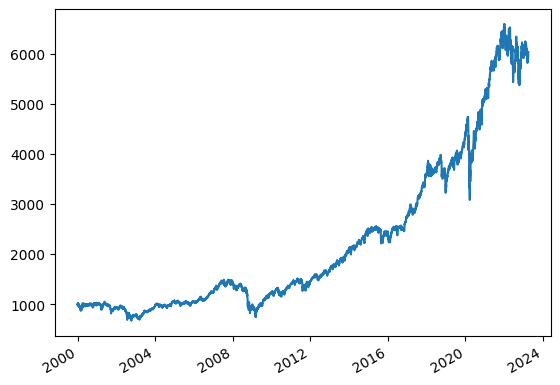

In [5]:
from src.core import strategy
from src.core import metrics
import yfinance as yf

prices = yf.download("XLU, XLK, XLB, XLP, XLY, XLI, XLV, XLF")["Adj Close"]

strategy = strategy.RiskParity(prices, reb_frequency="D").simulate(min_volatility=0.12)
strategy.value.plot()
print(strategy.analytics())


In [ ]:
strategy.value.sort_index().plot()